# Set-up environment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("../utilities")

from explore_data import (
    analyze_numerical_statistics
)
from visualize import (
    plot_numerical_distributions
)

# Load data

In [2]:
df = pd.read_csv("../Data/cleaned.csv")
df.sample()

,title,description,location,address,street_name,price,area,date,air_conditioning,fridge,washing_machine,mezzanine,kitchen,wardrobe,bed,balcony,elevator,free_time,parking,url
3799,"30/09 TRỐNG, phòng rộng 50m2, bếp tách phòng n...","MÌNH CHÍNH CHỦ, CAM KẾT PHÒNG Y NHƯ HÌNH 100% ...","số 10 Đường số 14, Phường Hiệp Bình Chánh, Thủ...",Thủ Đức - Hồ Chí Minh,Số Đưường Số 14,5.0,50.0,2025-09-03,1,1,1,1,1,1,1,1,1,1,1,https://phongtro123.com/phong-cuc-rong-50m2-mo...


# I. Dataset Overview


## 1. Basic Information

In [3]:
num_rows, num_cols = df.shape
size = num_rows * num_cols
print(f'Số hàng: {num_rows}')
print(f'Số cột: {num_cols}')
print(f'Overall size: {size}')
print('Mỗi dòng đại diện: Thông tin cho thuê phòng trọ')

Số hàng: 24121
Số cột: 20
Overall size: 482420
Mỗi dòng đại diện: Thông tin cho thuê phòng trọ


In [4]:
duplicate = df.duplicated().sum()
rows_empty = df.isnull().all(axis = 1).sum()
print(f'Số dòng trùng: {duplicate}')
print(f'Số dòng trống: {rows_empty}')

Số dòng trùng: 135
Số dòng trống: 0


Có thể do bị đăng lại nhiều lần hoặc do có dữ liệu mới đẩy bài đăng xuống khiến cho bị trùng khi thu thập dữ liệu do đó ta sẽ xóa bớt các dòng trùng

In [5]:
df = df.drop_duplicates()

## 2. Column Inventory


### Column Definitions

| Column | Definition |
| :--- | :--- |
| **title** | Tiêu đề bài đăng cho thuê. |
| **description**| Mô tả chi tiết thêm . |
| **location**| Địa chỉ chi tiết của bất động sản. |
| **address** | Địa chỉ 2 cấp của bất động sản (quận và thành phố). |
| **street_name** | Tên đường. |
| **price** | Giá cho thuê (VNĐ/Tháng). |
| **area** | Diện tích sử dụng ($m^2$). |
| **date** | Ngày đăng tin. |
| **air_conditioning** | Có máy lạnh không? (0: Không, 1: Có) |
| **fridge** | Có tủ lạnh không? (0: Không, 1: Có) |
| **washing_machine** | Có máy giặt không? (0: Không, 1: Có) |
| **mezzanine** | Có gác lửng không? (0: Không, 1: Có) |
| **kitchen** | Có kệ bếp không? (0: Không, 1: Có) |
| **wardrobe** | Có tủ quần áo không? (0: Không, 1: Có) |
| **bed** | Có giường không? (0: Không, 1: Có) |
| **balcony** | Có ban công không? (0: Không, 1: Có) |
| **elevator** | Có thang máy không? (0: Không, 1: Có) |
| **free_time** | Giờ giấc tự do/không giới nghiêm? (0: Không, 1: Có) |
| **parking** | Có chỗ để xe không? (0: Không, 1: Có) |
| **url** | Đường dẫn gốc tới bài đăng. |
			
### 2. Which columns are relevant to potential analysis?

Để xây dựng mô hình dự đoán và phân tích giá thuê, các cột dữ liệu được phân loại dựa trên vai trò của chúng trong mô hình như sau:

* **Target Variable:**
    * `price`: Giá cho thuê (VNĐ/Tháng) - Đây là giá trị cần dự đoán (Label).

* **Input Features:**
    * **Nhóm Vị trí & Diện tích:**
        * `area`, `address` (Quận), `street_name`.
        * **Ý nghĩa:** Đây là các đặc trưng quan trọng nhất . Vị trí địa lý và diện tích sử dụng là hai yếu tố cốt lõi quyết định phần lớn giá trị của bất động sản.

    * **Nhóm Tiện ích & Nội thất:**
        * `air_conditioning`, `mezzanine`, `elevator`, `parking`, `washing_machine`, `fridge`, `bed`, `wardrobe`, `kitchen`, `balcony`.
        * **Ý nghĩa:** Sự hiện diện của các tiện ích này (dạng Binary 0/1) giúp phân loại phân khúc phòng (Cao cấp vs Bình dân) và giải thích các biến động giá chi tiết trong cùng một khu vực.

    * **Nhóm Thời gian:**
        * `date`.
        * **Ý nghĩa:** Cần thiết để phân tích xu hướng giá theo thời gian (Trend Analysis) hoặc tính toán tuổi thọ của tin đăng (Recency).

    * **Nhóm Thông tin bổ trợ:**
        * `description`, `location`.
        * **Ý nghĩa:** Chứa các thông tin tiềm ẩn . Có thể sử dụng kỹ thuật NLP (như TF-IDF hoặc Embedding) để trích xuất thêm đặc trưng nhằm cải thiện độ chính xác của mô hình.

### 3. Are there any columns that should be dropped?

| Column | Action | Reason & Solution |
| :--- | :--- | :--- |
| **url** | **Drop** | **Lý do:** Đây là dữ liệu định danh kỹ thuật, mang tính chất duy nhất cho mỗi bài đăng và không chứa thông tin tổng quát về đặc điểm căn nhà.<br>**Giải pháp:** Xóa khỏi tập dữ liệu huấn luyện. |
| **title** & **description**| **Process / Drop** | **Lý do:** Dữ liệu dạng văn bản tự do (unstructured text), chứa nhiều nhiễu và khó đưa trực tiếp vào mô hình.<br>**Giải pháp:** Có thể dùng Regex để trích xuất thêm đặc điểm ẩn (VD: "gần chợ", "an ninh") rồi xóa cột gốc. Nếu không xử lý NLP, nên Drop để tránh nhiễu. |
| **location** | **Feature Engineering** | **Lý do:** Chứa thông tin chi tiết hơn `street_name` và `address`.<br>**Giải pháp:** <br>1. **Ưu tiên:** Giữ `address` và `street_name` để phân tích nhằm hiểu dữ liệu hơn.<br>2. **Nâng cao:** Có thể thử nghiệm **Embedding (Word2Vec/TF-IDF)** cột `location` để bắt các đặc điểm ngầm (như số nhà, hẻm, phường) bổ trợ cho model. |
| **date** | **Process** | **Lý do:** Máy tính không hiểu định dạng ngày tháng `YYYY-MM-DD`.<br>**Giải pháp:** Chuyển đổi thành các đặc trưng số: `month` (mùa vụ), `year` (lạm phát), hoặc `days_since_posted` (tuổi thọ tin đăng). |

## 3. Data Types

In [11]:
df.dtypes

title                object
description          object
location             object
address              object
street_name          object
price               float64
area                float64
date                 object
air_conditioning      int64
fridge                int64
washing_machine       int64
mezzanine             int64
kitchen               int64
wardrobe              int64
bed                   int64
balcony               int64
elevator              int64
free_time             int64
parking               int64
url                  object
dtype: object

### 3.1. What is the current data type of each column?

Dựa trên kết quả kiểm tra `df.dtypes`, dữ liệu hiện tại được phân loại như sau:

* **Object:** `title`, `description`, `location`, `address`, `street_name`, `date`, `url`.
* **Int64:** `air_conditioning`, `fridge`, `washing_machine`, `mezzanine`, `kitchen`, `wardrobe`, `bed`, `balcony`, `elevator`, `free_time`, `parking`.
* **float64:** `price`,`area`.

### 3.2. Identification of Inappropriate Data Types
**(Câu hỏi: Are there columns with inappropriate data types?)**

Có, sau khi rà soát, ta phát hiện cột **`date`** đang có kiểu dữ liệu chưa phù hợp:

  **Vấn đề:** Cột `date` mang ý nghĩa thời gian nhưng đang được lưu dưới dạng `object` (chuỗi ký tự).

  **Hệ quả:** Không thể thực hiện các phép tính toán học (cộng/trừ ngày), lọc dữ liệu theo tháng/năm hoặc phân tích chuỗi thời gian (Time Series Analysis).


### 3.3. Conversion Strategy
**(Câu hỏi: Which columns need type conversion?)**

Kế hoạch chuyển đổi định dạng dữ liệu được tóm tắt trong bảng dưới đây:

| Cột (Column) | Kiểu hiện tại | Kiểu mong muốn | Lý do & Mục đích |
| :--- | :--- | :--- | :--- |
| **date** | `object` | **`datetime64[ns]`** | Cần chuyển sang dạng thời gian chuẩn để trích xuất ngày, tháng, năm phục vụ phân tích xu hướng (Trend Analysis). |



# II. Numerical Columns Analysis

## 1. Phân tích thống kê mô tả 

Bước đầu tiên, chúng ta tính toán các chỉ số thống kê cơ bản để có cái nhìn tổng quan về dữ liệu số. Các chỉ số quan trọng bao gồm:

* **Độ đo xu hướng trung tâm:** `Mean` và `Median`.
* **Độ phân tán:** `Std` , `Min`, `Max`.
* **Hình dáng phân phối (Skewness):** Đánh giá độ lệch của dữ liệu:
    * $Skew > 1$: Phân phối lệch phải (đuôi dài về phía giá trị lớn).
    * $Skew < -1$: Phân phối lệch trái.
    * Khác: Tương đối đối xứng.
* **Phát hiện Outliers:** Sử dụng phương pháp IQR . Các điểm dữ liệu nằm ngoài khoảng $[Q1 - 1.5*IQR, Q3 + 1.5*IQR]$ được coi là ngoại lai.
* **Kiểm tra tính hợp lệ:** Đếm số lượng giá trị bị thiếu, giá trị phi lý (`<= 0`) hoặc các `Placeholders`.

**Kết quả phân tích:**

In [7]:
numerical_cols = ['price', 'area']
summary_df = analyze_numerical_statistics(df, numerical_cols)
display(summary_df)

,Column,Mean,Median,Std,Skew,Shape,Min,Max,Lower Bound,Upper Bound,Outliers Count,Percentage Outliers,Missing (%),Impossible (<=0),Placeholders
0,price,3.80,3.8,2.30,59.84,Lệch phải,0.1,260.000025,0.35,7.15,291,1.21%,0.25%,0,None
1,area,28.07,25.0,17.33,15.91,Lệch phải,0.0,1000.000000,5.00,45.00,830,3.46%,0.03%,13,0


## 2. Trực quan hóa phân phối 

Để hiểu rõ hơn về cấu trúc dữ liệu, chúng ta sử dụng hai loại biểu đồ cho mỗi biến số:

1.  **Histogram (kết hợp đường KDE):**
    * Giúp quan sát hình dạng phân phối thực tế của dữ liệu.
    * Đường nét đứt màu đỏ thể hiện giá trị trung bình (`Mean`).
    * *Lưu ý:* Để biểu đồ hiển thị rõ ràng hơn, dữ liệu hiển thị đã được loại bỏ 0.5% các giá trị lớn nhất giúp tránh việc biểu đồ bị "bẹt" do khoảng giá trị quá rộng.

2.  **Box Plot:**
    * Giúp nhìn nhanh các tứ phân vị ($25\%, 50\%, 75\%$).
    * Các điểm nằm ngoài "râu" của hộp đại diện cho các giá trị ngoại lai.

**Biểu đồ phân phối:**

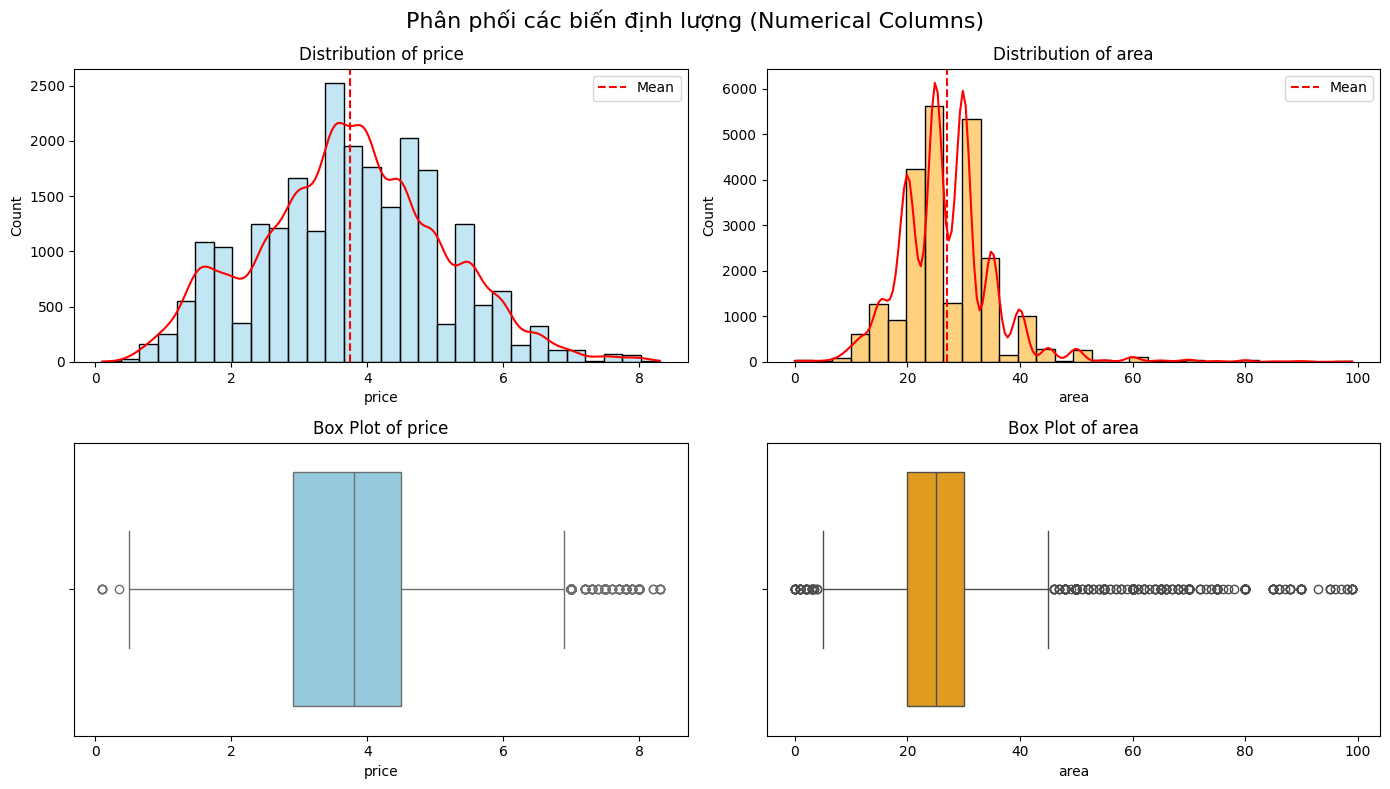

In [8]:
plot_numerical_distributions(df, numerical_cols)

## 1. Distribution & Central Tendency 

### **Price**
* **Distribution Shape:**
    * Phân phối **lệch phải nặng** với hệ số Skew $\approx 59.84$.
    * Đuôi phân phối kéo dài về phía giá trị cao, phản ánh sự tồn tại của các bất động sản giá trị rất lớn.
* **Central Tendency:**
    * **Mean:** 3.8 triệu.
    * **Median:** 3.8 triệu.
    * **Nhận xét:** Mặc dù dữ liệu bị lệch, Mean và Median xấp xỉ bằng nhau. Điều này cho thấy phần lớn dữ liệu tập trung dày đặc quanh mức 3.8 triệu, và các giá trị ngoại lai tuy lớn nhưng số lượng chưa đủ áp đảo để kéo Mean lệch hẳn khỏi Median.

### **Area**
* **Distribution Shape:**
    * Phân phối **lệch phải** với hệ số Skew $\approx 15.91$.
    * Biểu đồ Histogram hiển thị dạng **đa đỉnh**, với các đỉnh tập trung tại các mốc diện tích chẵn (ví dụ: 20, 25, 30 $m^2$), phản ánh đặc thù xây dựng theo module của phòng trọ/chung cư mini.
* **Central Tendency:**
    * **Mean (28.07 $m^2$) > Median (25.0 $m^2$).**
    * **Nhận xét:** Sự chênh lệch này xác nhận phân phối bị kéo bởi các bất động sản có diện tích lớn (chung cư nguyên căn, nhà ở).


## 2. Range & Outliers 

### **Range**
* **Price:** 0.1 - 260 triệu.
    * Min = 0.1 là giá trị đáng ngờ (có thể là lỗi nhập liệu hoặc đơn vị sai).
* **Area:** 0 - 1000 $m^2$.
    * Min = 0 là lỗi dữ liệu chắc chắn.

### **Outliers**
* **Phương pháp:** IQR Method (Box Plots).
* **Kết quả:**
    * **Price:** 291 outliers (1.21%), ngưỡng trên (Upper Bound) $\approx$ 7.15 triệu.
    * **Area:** 830 outliers (3.46%), ngưỡng trên (Upper Bound) $\approx$ 45 $m^2$.
* **Đánh giá & Phân loại:**
    * **Genuine:** Các giá trị cao **vừa phải** (ví dụ: Price 8-20 triệu, Area 45-80 $m^2$) có khả năng cao là dữ liệu thực (chung cư, nguyên căn).
    * **Suspicious/Errors:** Các giá trị **cực lớn** ( như Max Price = 260 triệu, Max Area = 1000 $m^2$) có nguy cơ cao là lỗi nhập liệu (thừa số 0, nhầm giá bán, hoặc nhầm diện tích đất).
    * **Hành động:** Cần kiểm tra chéo cột **Price/Area** . Nếu đơn giá quá vô lý (quá cao hoặc quá thấp), cần loại bỏ.
## 3. Data Quality 

### **Missing Values**
* Tỷ lệ rất thấp, không đáng lo ngại:
    * **Price:** 0.25%
    * **Area:** 0.03%

### **Impossible Values**
* **Area:** Phát hiện **13 dòng** có giá trị $\le 0$. Đây là dữ liệu rác cần loại bỏ.
* **Price:** Không có giá trị âm, nhưng giá trị thấp nhất 0.1 (có thể là lỗi nhập liệu).

### **Placeholders**
* Số `0` trong cột Area đang được sử dụng như placeholder cho dữ liệu thiếu hoặc lỗi hệ thống.

## **Đề xuất xử lý**
1.  **Cleaning:** Xóa 13 dòng `Area <= 0` và các dòng `Price` quá thấp (ví dụ < 0.5 triệu) nếu không xác minh được.
2.  **Outlier Handling :** Áp dụng phương pháp **Cắt bỏ theo ngưỡng** thay vì giữ lại toàn bộ.
    * **Thiết lập khoảng hợp lý:** Ước lượng khoảng giá và diện tích thực tế cho bài toán (Ví dụ: Price từ 0.5 - 50 triệu, Area từ 3 - 100 $m^2$).
    * **Hành động:** Loại bỏ hoàn toàn các dòng dữ liệu nằm ngoài khoảng này (bao gồm cả các giá trị quá nhỏ là lỗi và giá trị quá lớn nghi ngờ là nhập sai đơn vị). Việc này giúp mô hình tập trung vào phân khúc phổ biến và giảm nhiễu.
3.  **Imputation:** Với tỷ lệ missing < 1%, ưu tiên phương án xóa dòng để giữ độ sạch của dữ liệu gốc.